In [3]:
import os
import numpy as np
import env_ingredient_add as env
import hw
import trajectories as traj
from importlib import reload
from enum import Enum
import inverse_kinematics as ik
from manipulation.meshcat_utils import AddMeshcatTriad
import pizza_state as ps

def get_scene():
    if os.getcwd() == "/datasets/_deepnote_work/manipulation/project": 
        #scene = open("/work/manipulation/project/objects/environment_setup.yaml")
        scene = env.get_environment_set_up(no_scene=True,include_driver=True)
        xmls = [os.getcwd() + "/package.xml", "/work/manipulation/project/package.xml"]
    else:
        #scene = open("objects/environment_setup.yaml") # local setup
        scene = env.get_environment_set_up(no_scene=False,include_driver=True)
        xmls = [os.getcwd() + "/package.xml"]

    return scene

In [ ]:
reload(env)
scenario = hw.LoadScenario(data=get_scene())
# meshcat = hw.StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


### execute a plan

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl


Transitioning to PizzaRobotState.MOVE_TO_BOWL_0 FSM state.
Transitioning to PizzaRobotState.LIFT_BOWL_0 FSM state.
Transitioning to PizzaRobotState.MOVE_TO_BREADPAN FSM state.
Transitioning to PizzaRobotState.EVAL_PIZZA_STATE FSM state.
Transitioning to PizzaRobotState.SHIMMY_SHAKE FSM state.
Transitioning to PizzaRobotState.EXECUTE_SHIMMY_SHAKE FSM state.
Transitioning to PizzaRobotState.DIFF_IK_MOVE_TO_BREADPAN FSM state.
Transitioning to PizzaRobotState.EVAL_PIZZA_STATE FSM state.


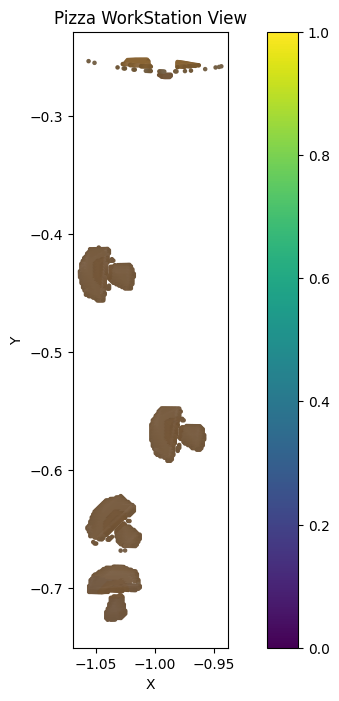

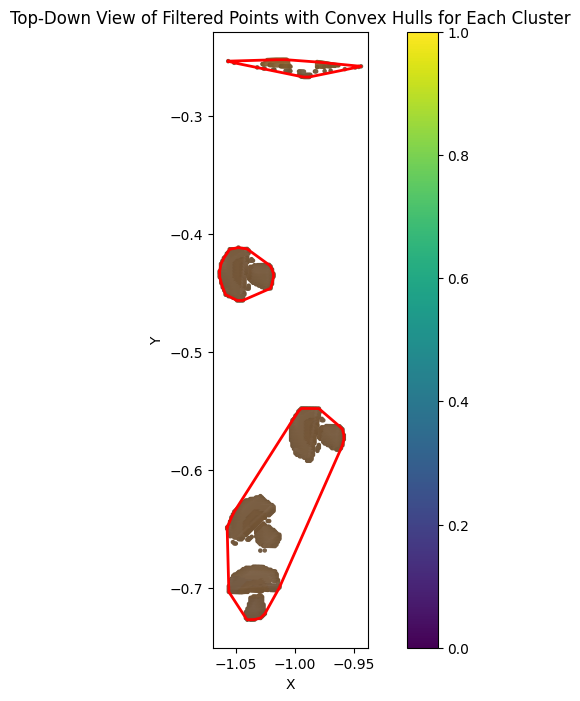

mushroom_ratio=12.350053865522836
Transitioning to PizzaRobotState.SHIMMY_SHAKE FSM state.
Transitioning to PizzaRobotState.EXECUTE_SHIMMY_SHAKE FSM state.
Transitioning to PizzaRobotState.DIFF_IK_MOVE_TO_BREADPAN FSM state.
Transitioning to PizzaRobotState.EVAL_PIZZA_STATE FSM state.


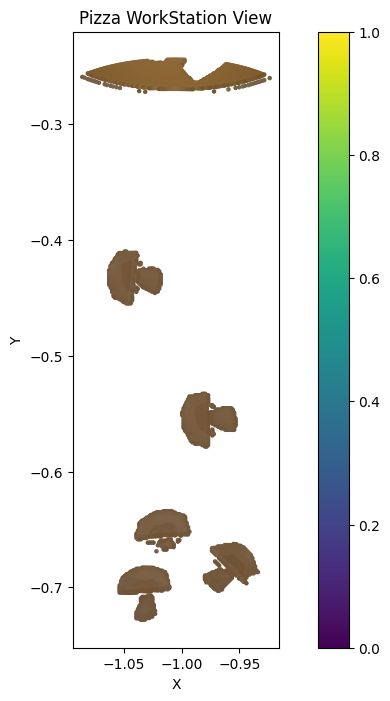

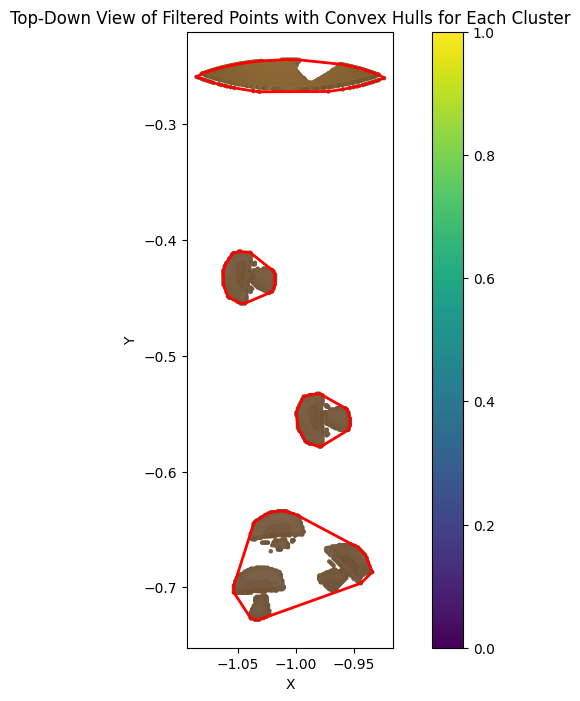

mushroom_ratio=14.27758968951251
Transitioning to PizzaRobotState.RELEASE_BOWL_0 FSM state.
Transitioning to PizzaRobotState.FINISHED FSM state.
Task is finished.


In [5]:
reload(env)
reload(traj)
reload(hw)
reload(ps)

# at present, trajectory blank doesn't work
diagram,sim = hw.init_diagram(meshcat,scenario)
# hw.print_diagram(diagram)

context = diagram.CreateDefaultContext()

controller = diagram.GetSubsystemByName("diff_ik_with_params")
plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")

hw.run_simulation(meshcat,sim,30)

In [ ]:
meshcat.PublishRecording()

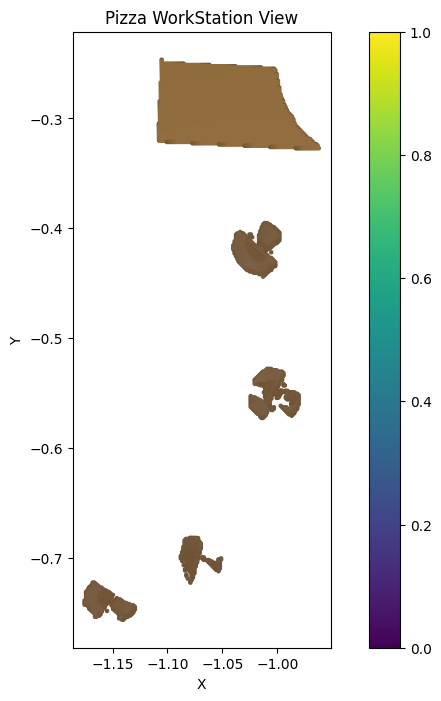

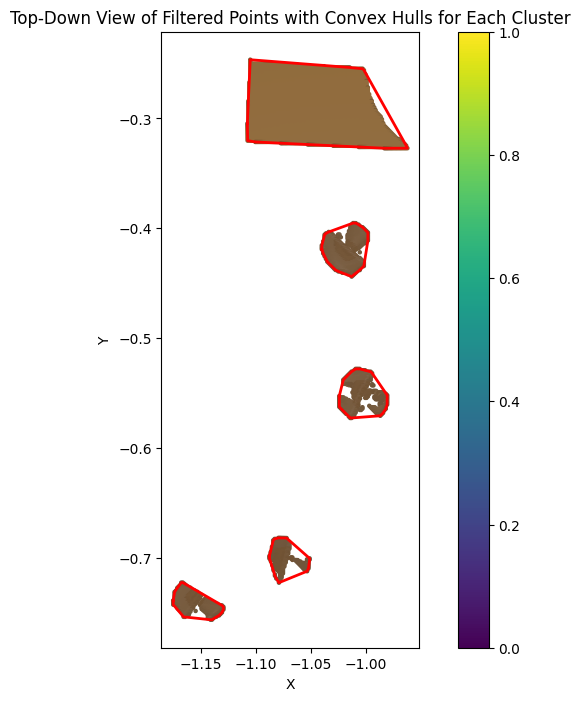

In [15]:
sim_context = sim.get_context()
point_cloud = diagram.GetOutputPort("table_camera_0_ptcloud").Eval(sim_context)

points = point_cloud.xyzs().T
# print(points)
colors = point_cloud.rgbs().T.reshape(-1, 3)/255.0

# self._area_of_pizza = ps.calculate_pizza_area(points, colors)

mushroom_ratio = ps.calculate_mushroom_to_pizza_ratio(points, colors, 0.09,True,True)

In [44]:
# sim.AdvanceTo(100)
meshcat.PublishRecording()

In [ ]:
sim.

In [ ]:
# hw.print_diagram(diagram,output_file="planner.png")

Diagram saved to planner.png


In [30]:
hw.run_simulation(meshcat,sim,0.5)

AttributeError: 'ParameterUpdater' object has no attribute 'num_positions'

In [16]:
gripper_frame = plant.GetFrameByName("body")
plant_context = plant.GetMyMutableContextFromRoot(context)
gripper_pose_in_world = plant.CalcRelativeTransform(plant_context, plant.world_frame(), gripper_frame)
# print(gripper_pose_in_world)
AddMeshcatTriad(meshcat, X_PT=gripper_pose_in_world, path="gripper_frame")

In [35]:
hw.print_diagram(diagram,output_file="planner.png")

Diagram saved to planner.png


In [ ]:
# hw.fix_base_pos(controller.get_parameters(), 0*[False]+3*[True]) # z is locked to 25 cm.
# hw.create_painter_trajectory(diagram,meshcat)



In [5]:
sim.AdvanceTo(20)
meshcat.PublishRecording()

Transitioning to PizzaRobotState.FINISHED FSM state.
Task is finished.


## scratch code

In [ ]:
plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
plant.GetJointByName("")

AttributeError: 'pydrake.multibody.plant.MultibodyPlant' object has no attribute 'GetJointNames'

### gets the name of the robot's joints

In [ ]:

# plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")

# for index in plant.GetJointIndices():
#     print(plant.get_joint(index).name())

In [ ]:


print(controller.get_parameters().get_joint_position_limits())

print(f"after running: {controller.get_parameters().get_joint_position_limits()}")

hw.run_simulation(meshcat,sim,10)

# Camera Stuff

In [ ]:
import pizza_state as ps 
reload(ps)


cameras = []
cameras.append(ps.CameraSystem(0, meshcat, diagram, context))

point_cloud = diagram.GetOutputPort("table_camera_0_ptcloud").Eval(context)

#Visualize the point cloud
ps.plt.imshow(cameras[0].rgb_im)
ps.plt.title("View from camera 0")
ps.plt.show()



# # Example Use / How to use in State Machine

#Point cloud and colors: 
points = point_cloud.xyzs().T
colors = point_cloud.rgbs().T.reshape(-1, 3)/255.0

#Get area of pizza
area_of_pizza = ps.calculate_pizza_area(points, colors)
# Print the total area
print(f"Total area of pizza: {area_of_pizza}")

#Get ingredient to pizza ratio

ratio_tomatoes = ps.calculate_tomato_to_pizza_ratio(points, colors, area_of_pizza)
ratio_mushy = ps.calculate_mushroom_to_pizza_ratio(points, colors, area_of_pizza)

print(f"Total area covered by the filtered points (in %): {ratio_tomatoes}")
print(f"Total area covered by the filtered points (in %): {ratio_mushy}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=92fbdad2-a4a9-4ef8-b493-c307060b34a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>